<a href="https://colab.research.google.com/github/ManaliMisra/FinalProject/blob/main/Markov_SIR_Epidemic_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 🧬 A Tale of Two Cities: A Markovian Pandemic Chronicle

## 🎯 Project Goal

This notebook simulates disease spread using a grid-based SIR (Susceptible-Infected-Recovered) model, incorporating demographics, infection zones, and Markov Chains. It provides side-by-side simulations of:

1. **Two cities with different demographics and densities**: "Metroburg" (young, urban) vs "Eldertown" (elderly, rural)
2. **Two diseases**: Flu (mild, common) vs Measles (highly contagious)
3. **Vaccination interventions**: Effects of vaccinating different age groups

The simulation also highlights how Markov models differ from spatial simulations and what epidemiologists can learn from both approaches.


In [7]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


In [8]:

# 🧩 Common parameters
grid_size = 30
steps = 50

# Age groups: 0 = young, 1 = adult, 2 = elderly
age_labels = ["Young", "Adult", "Elderly"]

# Color map for SIR
cmap = plt.cm.get_cmap('viridis', 3)

def apply_vaccination(grid, age_grid, coverage=0.5, target_age=0):
    """Applies vaccination to a portion of the population of a target age group"""
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            if age_grid[i, j] == target_age and np.random.rand() < coverage:
                grid[i, j] = 2  # Recovered = vaccinated
    return grid


<ipython-input-8-06e4713450a5>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', 3)


In [9]:

def run_simulation(p_infection, p_loss_immunity, recovery_probs, age_distribution, density_value,
                   apply_vaccine=False, vaccine_age=0, vaccine_coverage=0.5, label=""):
    # Initialize grid
    grid = np.zeros((grid_size, grid_size), dtype=int)
    center = grid_size // 2
    grid[center, center] = 1  # One infection starts at center

    # Age grid
    age_grid = np.random.choice([0, 1, 2], size=(grid_size, grid_size), p=age_distribution)

    # Density map
    density_map = np.ones((grid_size, grid_size)) * density_value
    density_map[10:20, 10:20] *= 1.5  # Center is a hotspot

    # Apply vaccination if enabled
    if apply_vaccine:
        grid = apply_vaccination(grid, age_grid, coverage=vaccine_coverage, target_age=vaccine_age)

    # History
    S_history, I_history, R_history = [], [], []

    # Markov chain theoretical prediction
    S = np.sum(grid == 0)
    I = np.sum(grid == 1)
    R = np.sum(grid == 2)

    state_vector = np.array([S, I, R]) / (grid_size**2)
    theory_S, theory_I, theory_R = [state_vector[0]], [state_vector[1]], [state_vector[2]]

    # Transition matrix (SIR)
    P = np.array([
        [1 - p_infection, p_infection, 0],
        [0, 1 - 0.1, 0.1],
        [p_loss_immunity, 0, 1 - p_loss_immunity]
    ])

    # Simulation
    for step in range(steps):
        new_grid = grid.copy()
        for i in range(grid_size):
            for j in range(grid_size):
                if grid[i, j] == 0:  # Susceptible
                    neighbors = grid[max(0, i-1):min(grid_size, i+2),
                                     max(0, j-1):min(grid_size, j+2)]
                    if np.any(neighbors == 1) and np.random.rand() < p_infection * density_map[i, j]:
                        new_grid[i, j] = 1
                elif grid[i, j] == 1:  # Infected
                    age = age_grid[i, j]
                    if np.random.rand() < recovery_probs[age]:
                        new_grid[i, j] = 2
                elif grid[i, j] == 2:  # Recovered
                    if np.random.rand() < p_loss_immunity:
                        new_grid[i, j] = 0
        grid = new_grid

        # Record states
        S = np.sum(grid == 0)
        I = np.sum(grid == 1)
        R = np.sum(grid == 2)
        S_history.append(S)
        I_history.append(I)
        R_history.append(R)

        # Markov update
        last_state = np.array([theory_S[-1], theory_I[-1], theory_R[-1]])
        next_state = last_state @ P
        theory_S.append(next_state[0])
        theory_I.append(next_state[1])
        theory_R.append(next_state[2])

    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    ax[0].plot(S_history, label="S (Sim)", color='blue')
    ax[0].plot(I_history, label="I (Sim)", color='red')
    ax[0].plot(R_history, label="R (Sim)", color='green')
    ax[0].set_title(f"SIR Over Time: {label}")
    ax[0].legend()

    ax[1].plot(theory_S, '--', label="S (Markov)", color='blue')
    ax[1].plot(theory_I, '--', label="I (Markov)", color='red')
    ax[1].plot(theory_R, '--', label="R (Markov)", color='green')
    ax[1].set_title(f"Theoretical Prediction: {label}")
    ax[1].legend()
    plt.tight_layout()
    plt.show()



## 🏙️ Metroburg vs Eldertown: Demographic Comparison

We'll now simulate two cities with different age structures and densities:

- **Metroburg**: young, dense, fast recovery
- **Eldertown**: older, rural, slow recovery

This shows how population structure affects outbreak dynamics.


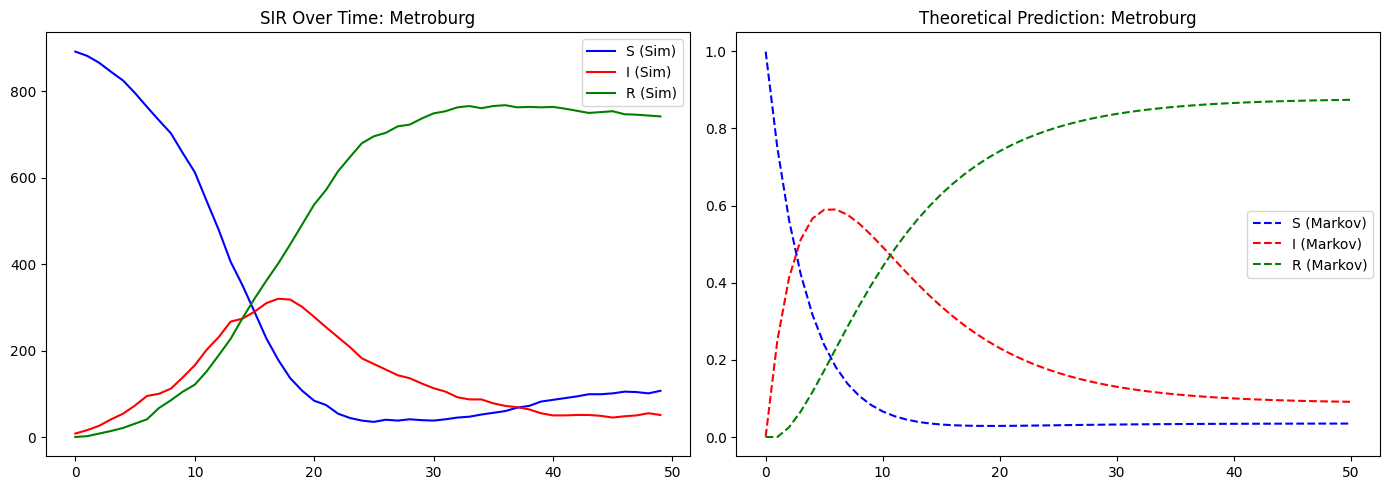

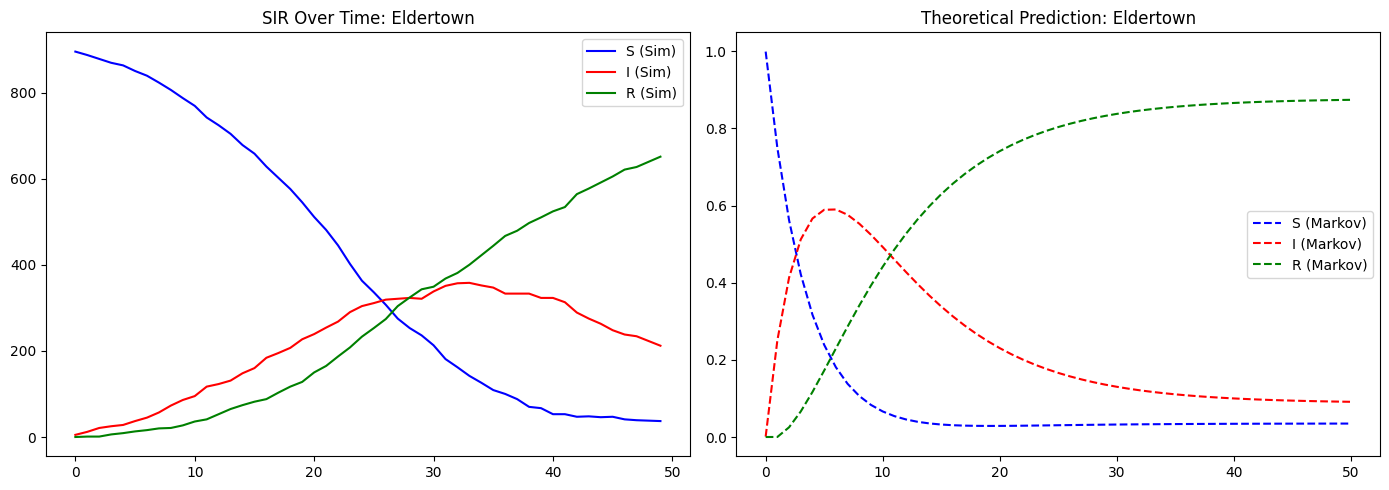

In [10]:

# Metroburg (young, urban)
run_simulation(
    p_infection=0.25,
    p_loss_immunity=0.01,
    recovery_probs=[0.3, 0.1, 0.05],
    age_distribution=[0.6, 0.3, 0.1],
    density_value=1.5,
    label="Metroburg"
)

# Eldertown (elderly, rural)
run_simulation(
    p_infection=0.25,
    p_loss_immunity=0.01,
    recovery_probs=[0.3, 0.1, 0.05],
    age_distribution=[0.1, 0.4, 0.5],
    density_value=0.8,
    label="Eldertown"
)



## 🧫 Flu vs Measles: Disease Comparison

Next, we compare two diseases:

| Disease | Infection Rate | Recovery Rate | Immunity Loss |
|---------|----------------|----------------|----------------|
| Flu     | 0.25           | Age-based      | 0.01           |
| Measles | 0.90           | 0.15 fixed     | 0.00           |


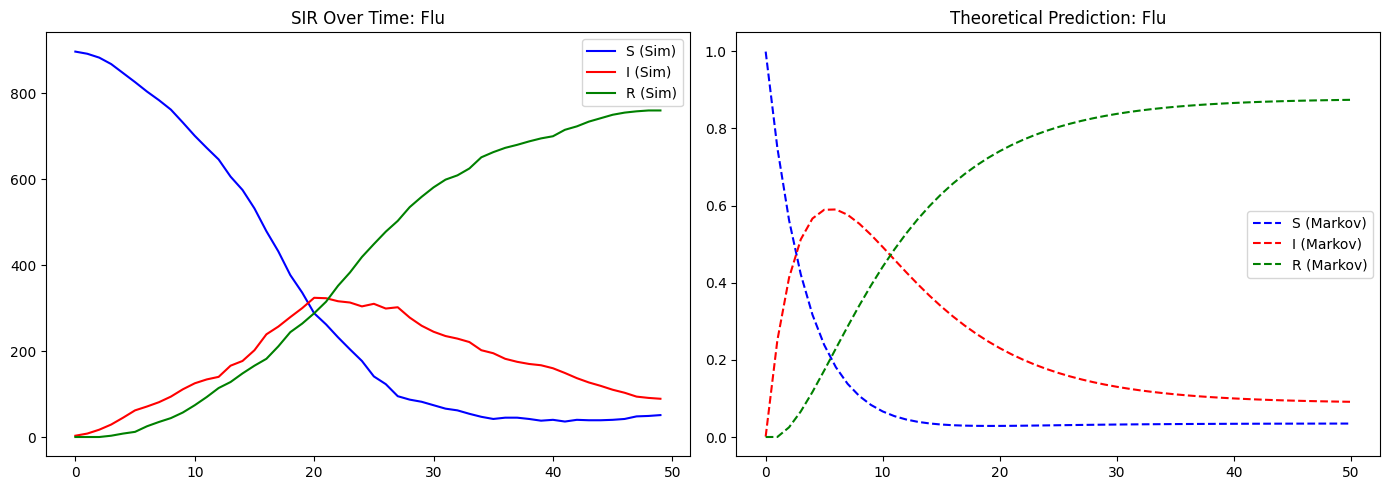

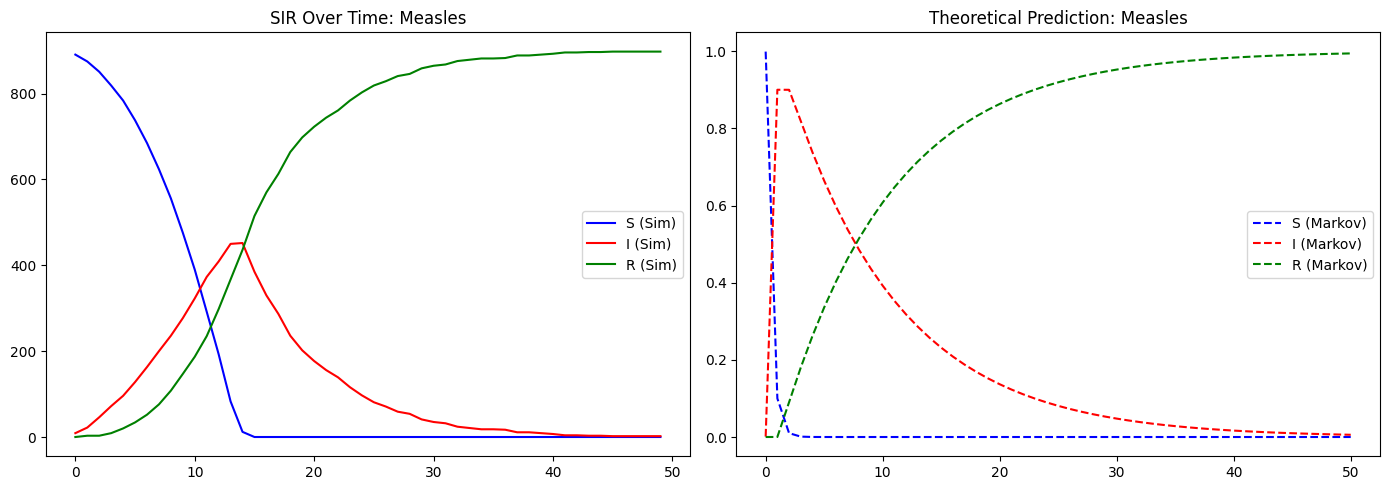

In [11]:

# Flu
run_simulation(
    p_infection=0.25,
    p_loss_immunity=0.01,
    recovery_probs=[0.3, 0.1, 0.05],
    age_distribution=[0.3, 0.5, 0.2],
    density_value=1.0,
    label="Flu"
)

# Measles
run_simulation(
    p_infection=0.90,
    p_loss_immunity=0.0,
    recovery_probs=[0.15, 0.15, 0.15],
    age_distribution=[0.3, 0.5, 0.2],
    density_value=1.0,
    label="Measles"
)



## 💉 Vaccination: Early Intervention Effects

We simulate the effect of vaccinating:

- Young population
- Elderly population

to evaluate their impact on controlling disease spread.


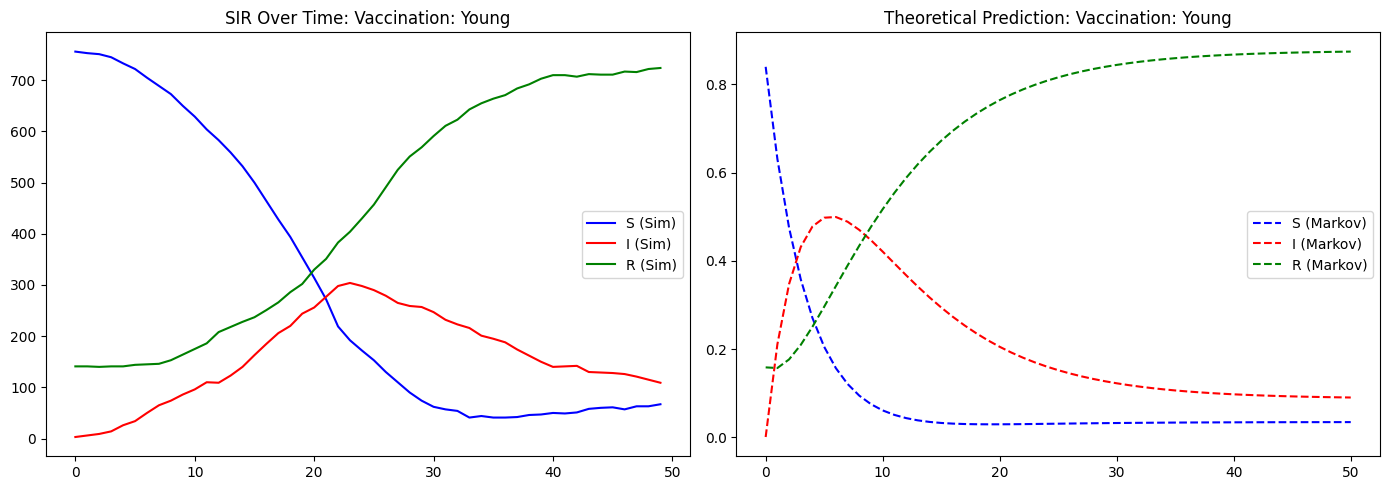

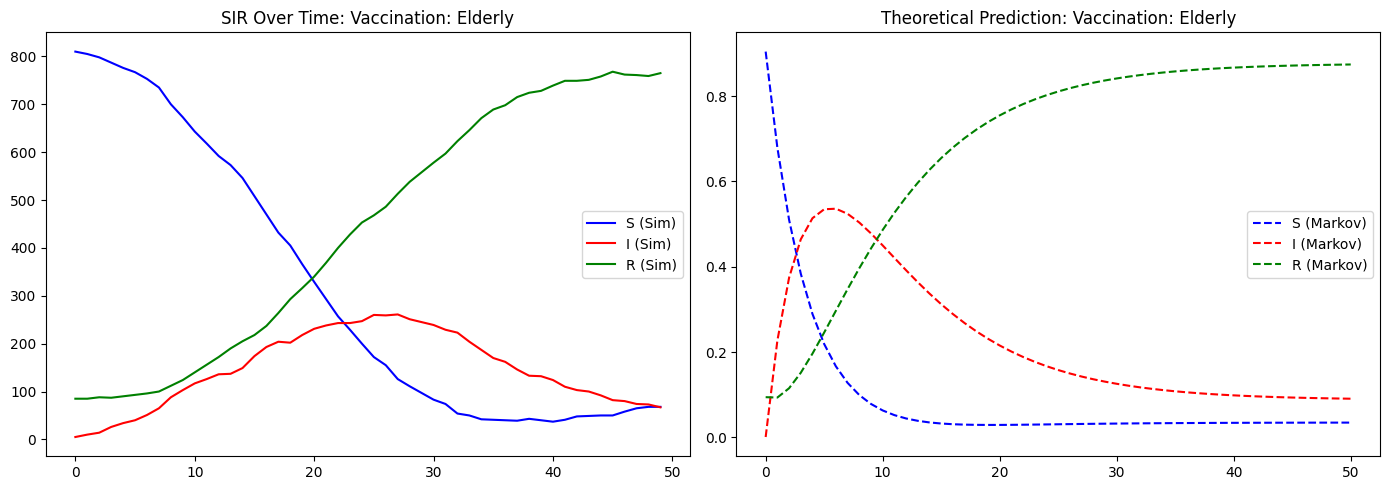

In [12]:

# Vaccinate young (0)
run_simulation(
    p_infection=0.25,
    p_loss_immunity=0.01,
    recovery_probs=[0.3, 0.1, 0.05],
    age_distribution=[0.3, 0.5, 0.2],
    density_value=1.0,
    apply_vaccine=True,
    vaccine_age=0,
    label="Vaccination: Young"
)

# Vaccinate elderly (2)
run_simulation(
    p_infection=0.25,
    p_loss_immunity=0.01,
    recovery_probs=[0.3, 0.1, 0.05],
    age_distribution=[0.3, 0.5, 0.2],
    density_value=1.0,
    apply_vaccine=True,
    vaccine_age=2,
    label="Vaccination: Elderly"
)



## 📚 Insights and Real-World Relevance

- **Markov Chains** offer fast predictions but ignore spatial patterns and local outbreaks.
- **Grid-based models** better capture superspreader zones and clustered risks.
- **Age and density** affect disease duration and peak infection rate.
- **Vaccination strategy** must consider population structure for maximum effect.

This project mimics tools epidemiologists use to inform policy—especially during pandemics like COVID-19.


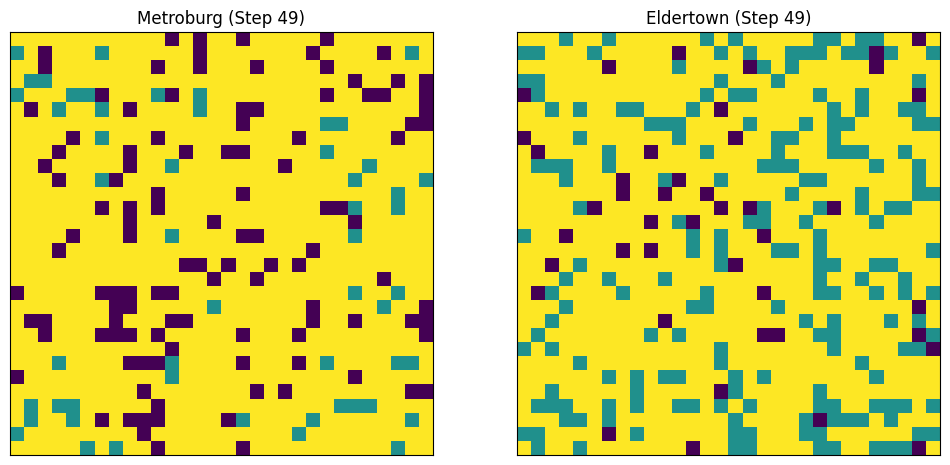

In [17]:
# 🧬 A Tale of Two Cities: Animated SIR Simulation with Markov Chains in Google Colab

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# ---- Simulation Parameters ----
grid_size = 30
steps = 50
p_infection = 0.25  # For both cities
p_loss_immunity = 0.01

# ---- Metroburg (Young, Urban) ----
grid1 = np.zeros((grid_size, grid_size), dtype=int)
grid1[grid_size // 2, grid_size // 2] = 1
age1 = np.random.choice([0, 1, 2], size=(grid_size, grid_size), p=[0.6, 0.3, 0.1])
density1 = np.ones((grid_size, grid_size))
density1[8:22, 8:22] = 1.8

# ---- Eldertown (Older, Rural) ----
grid2 = np.zeros((grid_size, grid_size), dtype=int)
grid2[grid_size // 2, grid_size // 2] = 1
age2 = np.random.choice([0, 1, 2], size=(grid_size, grid_size), p=[0.1, 0.4, 0.5])
density2 = np.ones((grid_size, grid_size)) * 0.8

# ---- Grid Update Logic ----
def update_grid(grid, age_grid, density_map):
    new_grid = grid.copy()
    for i in range(grid_size):
        for j in range(grid_size):
            if grid[i, j] == 0:  # Susceptible
                neighbors = grid[max(0, i-1):min(grid_size, i+2),
                                 max(0, j-1):min(grid_size, j+2)]
                if np.any(neighbors == 1) and np.random.rand() < p_infection * density_map[i, j]:
                    new_grid[i, j] = 1
            elif grid[i, j] == 1:  # Infected
                age = age_grid[i, j]
                p_r = 0.2 if age == 0 else (0.1 if age == 1 else 0.05)
                if np.random.rand() < p_r:
                    new_grid[i, j] = 2
            elif grid[i, j] == 2:  # Recovered
                if np.random.rand() < p_loss_immunity:
                    new_grid[i, j] = 0
    return new_grid

# ---- Set Up Plot ----
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
im1 = ax1.imshow(grid1, cmap='viridis', vmin=0, vmax=2)
im2 = ax2.imshow(grid2, cmap='viridis', vmin=0, vmax=2)
ax1.set_title("Metroburg (Urban, Young)")
ax2.set_title("Eldertown (Rural, Elderly)")

# Remove axis ticks
for ax in (ax1, ax2):
    ax.set_xticks([])
    ax.set_yticks([])

# ---- Animate Function ----
def animate(frame):
    global grid1, grid2
    grid1 = update_grid(grid1, age1, density1)
    grid2 = update_grid(grid2, age2, density2)
    im1.set_data(grid1)
    im2.set_data(grid2)
    ax1.set_title(f"Metroburg (Step {frame})")
    ax2.set_title(f"Eldertown (Step {frame})")
    return im1, im2

# ---- Run Animation ----
anim = FuncAnimation(fig, animate, frames=steps, interval=300, blit=True)
HTML(anim.to_jshtml())
